In [1]:
import pandas as pd
import numpy as np
import datetime
from collections import Counter

#api
import praw
import requests
from fake_useragent import UserAgent 
import time
import cryptocompare


#pre-processing
from nltk.corpus import stopwords 
from NLP_functions import clean_str, pos_only

#EDA
from NLP_functions import get_top_n_words, find_top_bigrams

#topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from NLP_functions import display_topics, prob_df, topic_matrix, top_topics_df
from gensim import matutils, models 

#sentiment analysis
from NLP_functions import get_sentiments

#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Intialize Reddit API

In [2]:
reddit = praw.Reddit(client_id='oCxykEUclueAuA', client_secret='M8wVQw3nFxMsXHLGxurnTtkN-Mdvtg', user_agent='Crypto')

#### Get top posts of all time

In [ ]:
posts = []
ml_subreddit = reddit.subreddit('Cryptocurrency')

#loop through top 1000 posts of all time, get data in list and append to dataframe as new row
for post in list(ml_subreddit.top('all', limit=1000)):
    date = datetime.datetime.utcfromtimestamp(post.created_utc)
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, date])
    
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'date'])
print(posts.info())

#### Get open day prices for BTC, ETH, DOGE, NANO, and XRB based on date of post

In [6]:
#create random user agent and get key for crypto price api
ua = UserAgent()
headers = {'user-agent': ua.random}
key = cryptocompare.cryptocompare._set_api_key_parameter('893488b8793438da44ad6d1e1093de1659841ad589583cf3f376dc468ffce72c')

In [11]:
cryptos = [ 'BTC', 'ETH', 'XRP','NANO', 'DOGE']

#loop through cryptocurrencies to get prices for 
for c in cryptos:
    l = []
    
    #loop through all posts to get timestamp, request price for cryptocurrecny based on timestamp and in usd
    for index, row in posts.iterrows():
        timestamp = (posts.loc[index,'date']).timestamp()
        url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={c}&tsym=USD&limit=1&toTs={timestamp}'
        url += key
        response = requests.get(url, headers=headers)  
        data = response.json()['Data']['Data']
        
        #append open day price to list
        l.append(data[1]['open'])
        
        if index%25 == 0:
            time.sleep(0.5) #pause every 25 loops
            
        #change user agent, chosen randomly every 50 loops
        if index%50 == 0:
            headers = {'user-agent': ua.random}
    
    #append all prices to new column   
    posts[c] = l

In [12]:
posts.info()
#save as pickle, cryptocompare API has limited requests
posts.to_pickle('../Data/posts_price_df.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         930 non-null    object        
 1   score         930 non-null    int64         
 2   id            930 non-null    object        
 3   subreddit     930 non-null    object        
 4   url           930 non-null    object        
 5   num_comments  930 non-null    int64         
 6   body          930 non-null    object        
 7   date          930 non-null    datetime64[ns]
 8   BTC           930 non-null    float64       
 9   ETH           930 non-null    float64       
 10  XRP           930 non-null    float64       
 11  NANO          930 non-null    float64       
 12  DOGE          930 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 94.6+ KB


#### Get top coments from each top post

In [13]:
all_top_comments = []
#loop through all posts to get top 20 comments from each post, append date and crypto prices
for index, row in posts.iterrows():

    try: #check that post actually exists or hasnt been deleted
        submission = reddit.submission(id=row['id'])
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments.list()])
        for x in comments[:20]:
            #check that comment hasnt been deleted or is not a reddit bot/moderator
            if x != '[deleted]' and 'Some Important Reminders' not in x and 'moderator' not in x: 
                all_top_comments.append([x,row[7], row[8], row[9], row[10], row[11], row[12]])

    except:
        comments=None
all_top_comments = pd.DataFrame(all_top_comments,columns=['comment', 'date', 'BTC', 'ETH', 'XRP', 'NANO', 'DOGE'])

## Cleaning

In [14]:
all_top_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17769 entries, 0 to 17768
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   comment  17769 non-null  object        
 1   date     17769 non-null  datetime64[ns]
 2   BTC      17769 non-null  float64       
 3   ETH      17769 non-null  float64       
 4   XRP      17769 non-null  float64       
 5   NANO     17769 non-null  float64       
 6   DOGE     17769 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 971.9+ KB


Add stop words

In [15]:
stop = stopwords.words('english')
stop = [w.replace("'", "") for w in stop] #remove apostrophes in stop words

stop = stop + ['moderator', 'subreddit', 'reddit' , 'question', 'concern', 'please', 'contact', 'im', 
        'people', 'gon', 'seems', 'something', 'year', 'like', 'mod', 'wa', 'thread', 'crypto', 'get',
        'see', 'deleted', 'ha', 'use', 'think', 'cryptocurrency', 'thing', 'one', 'even', 'want', 'need',
        'time', 'also', 'got', 'post', 'thats', 'probably', 'u', 'every', 'next', 'reason', 'na', 'give', 'lol',
        'everything', 'know', 'community', 'today', 'come', 'anyone', 'actually', 'removed', 'wtf', 'immage',
        'really', 'nice', 'man', 'work', 'day', 'way', 'would', 'could', 'said', 'submission', 'news', 'nice',
        'enjoy', 'find', 'work', 'job', 'flaired', 'inaccurately', 'click', 'action', 'performed', 'automatically',
        'ive', 'seen', 'sense', 'month', 'pretty', 'much', 'week', 'money', 'coin', 'market', 'right', 'let',
         'someone', 'guy', 'price', 'lot', 'transaction', 'feel', 'list', 'wow', 'well', 'go', 'take', 'thank',
        'something', 'shit', 'fuck', 'look', 'still', 'value', 'back', 'make', 'say', 'sure', 'new', 'happen',
        'buy', 'sell', 'word', 'start', 'trade', 'made', 'implement', 'gif', 'watch', 'worth', 'bought', 'sold',
        'total', 'idea', 'good', 'upvote', 'cant', 'never', 'love', 'oh', 'sub', 'repost', 'great', 'awesome',
        'best', 'quality', 'hope', 'big', 'discuss', 'project', 'believe', 'mean', 'virtual', 'trader',
        'user', 'payment', 'pay', 'try', 'many', 'bad', 'company', 'world', 'invest', 'stock', 'may', 'put',
        'first',  'point', 'already', 'everyon',  'ask',  'around', 'anoth', 'run', 'person'

            'keep', 'end', 'read', 'lose', 'gain', 'alway', 'understand', 'interest',  'last',
          'profit', 'life', 'edit', 'better', 'research', 'dollar', 'adopt',  'without',
         'amount', 'id', 'site',  'million',  'differ', 'help', 'tell', 'investor', 'sinc', 'went', 
         'decid',  'littl',  'inform', 'real', 'talk', 'noth', 'move', 'learn', 'small', 'chang', 
         'stop', 'compani', 'current', 'two', 'free', 'live', 'case',  'term', 
         'ga', 'send', 'card',  'check', 'game',  'full', 'cost',  'problem', 'transfer', 
         'top',  'platform', 'program', 'app', 'process', 'chain', 'issu', 
         'distribut', 'far', 'smart',  'gener', 'anyth', 'correct', 'system', 'huge', 'exist', 'ever', 
         'instead', 'advantag', 'easi',  'els', 'exampl', 'larg', 'creat', 'though', 'format', 
         'vote', 'either',   'support', 'tax', 'entir', 'cryptocurr', 'enough', 'might',
         'theyr', 'care', 'link',  'product', 'mayb', 'video', 'le', 'almost', 'posit', 
         'simpli', 'state', 'done', 'hard',  'internet', 'allow',  'complet', 'least', 'ill', 'fact', 
         'thought', 'stake', 'team', 'design', 'provid', 'stori', 'part', 'show', 'place', 'becom', 'data',
         'busi', 'articl', 'set', 'stuff',  'turn', 'howev', 'follow',  'call', 'possibl',
          'transact', 'order', 'block', 'agre', 'tech', 'ago', 'medium', 
          'respons',  'lost', 'low', 'option',  'past', 'yet',  'wrong', 'true',  
         'averag', 'must', 'number', 'rule', 'ye', 'hey', 'account', 'play', 'comment', 'major', 
         'away', 'hype', 'hous', 'save', 'activ', 'portfolio', 'rich', 'final', 'share', 'ignor', 'cours', 'name', 
         'expect', 'friend', 'economi', 'hand', 'extrem', 'mind', 'eventu', 'saw', 'side', 'claim', 'rather',
         'higher', 'liter', 'liquid', 'base', 'group', 'hear', 'control',  'push', 'due', 
         'kind',  'critic', 'whole', 'public',   'build', 'concept', 'specif',  'left', 
                
         'basic', 'releas',  'plan', 'abil', 'absolut',  'hour',  'add',  
         'loss', 'miss', 'easili', 'manag', 'potenti',  'guess',  'spend', 
         'whatev',  'sort',  'requir', 'standard', 'includ',  
         'rememb', 'bring', 'book', 'nobodi', 'longer', 'statement', 'act', 
         'opinion', 'belief', 'listen', 'rais', 'offer', 'solut', 'perspect', 
         'form', 'speak', 'wealth', 'found', 'strongli', 'heard', 'figur',  'answer', 
         'spent', 'accept', 'compar', 'reach',  'electr', 'miner',  'hit',  'replac',
         'stay', 'purchas',   'consid', 'reach',  'soon', 
         'imagin', 'per', 'renew',  'defy', 'built', 'attempt', 'earn', 'withdraw', 'effect', 'step', 
          'store', 'open', 'ad',  'singl', 'scale', 'zero', 'calcul', 
         'stabl',  'holder', 'fast', 'hit', 'plu', 'realiz', 'took',  'minut',  
          'return', 'chanc',  'digit', 'actual',  'billion', 
          'limit',  'old', 'seem', 'late', 'massiv', 'drive', 'wouldv',
               
         'coupl', 'strategi', 'earli', 'experi',  'happi', 'half',   'suppli', 'bigger', 
         'sustain',  'later', 'break', 'key', 'amaz',  'rel',  
         'comparison', 'meant', 'ride', 'caus', 'leav', 'told', 'note', 'decemb', 'crazi', 'exactli', 'consum', 
         'deal', 'sound', 'produc', 'serious', 'anyway', 'season',  'matter', 'becam',  
         'sever', 'recov', 'obvious', 'chart', 'sit', 'assum', 'win', 'lower', 'came',  
         'updat', 'websit', 'stupid',  'cool',  'access', 'moment', 'summari', 'fun', 
          'institut', 'forget', 'largest',  'estim', 'continu', 'biggest', 'lend', 
         'convert', 'multipl',  'settlement', 'simpl',  'tradit', 
         'report', 'proof', 'carri', 'similar', 'th', 'buck',  'begin', 'natur', 'wish', 'alon',  'sleep',
         'tangibl', 'perform', 'fail', 'popular', 'bot',
        'futur', 'high', 'rise', 'wait', 'beyond', 'financi', 'record', 'develop', 'effort', 'deposit', 'autom', 
        'monetari', 'force', 'impact','person', 'technic', 'contract', 'sourc', 'fair', 'subscrib','polit', 'softwar',
        'relat', 'captur', 'histori', 'practic', 'page','august', 'benefit', 'perhap', 'fan', 'neither', 'hater', 
        'hate', 'bullshit', 'clearli', 'straw', 'instant', 'custom', 'paid','volum', 'merchant', 'connect', 
               'network', 'valid', 'offic', 'resourc', 'announc', 'level', 'progress', 'plenti', 'ahead', 'success',
        'chief', 'address', 'industri', 'accus', 'necessarili', 'competitor', 'whose', 'determin', 'blockchain',
               'keep', 'funny', 'congratul', 'advic', 'weekend', 'reduc', 'verifi', 'wallet', 'toxic', 'emotion',
              'emote', 'remote', 'hold', 'currencies', 'eo', 'solv', 'emot', 'ration', 'node', 'usd',
              'volkswagen', 'tri']

stop = set(stop)

#dictionary for words/acronyms to replace
replace_values = {'btc': 'bitcoin', 
               'dogecoin': 'doge', 
               'bitcoin cash': 'bch', 
               'ethereum': 'eth', 
               'ripple': 'xrp'}

In [17]:
top_comments = all_top_comments.copy()
top_comments['cleaned_comments'] = top_comments.apply (lambda x: clean_str(x['comment'], stop, replace_values), axis=1)
top_comments.head()

,comment,date,BTC,ETH,XRP,NANO,DOGE,cleaned_comments
0,If your life savings hinges on a Tweet from a ...,2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,hing tweet billionair
1,I seriously don’t understand the obsession wit...,2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,obsess elon musk space signific tweet rekt bor...
2,"Tbh u can't place all the blame on Elon tho, t...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,tbh blame elon tho yolo doge dumb af yolo twee...
3,"seriously, there's so much more relevant peopl...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,relev cryptodltfintech obsess fascin idol norm...
4,"If I'm Elon, I put hundreds of millions into D...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,elon hundr doge dip tweet doge pull shock


Named find all nouns, verbs, and adjectives in cleaned comments

In [19]:
top_comments['nouns_verbs_adj'] = top_comments.apply (lambda row: pos_only(row), axis=1)
top_comments.head()

,comment,date,BTC,ETH,XRP,NANO,DOGE,cleaned_comments,nouns_verbs_adj
0,If your life savings hinges on a Tweet from a ...,2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,hing tweet billionair,tweet billionair
1,I seriously don’t understand the obsession wit...,2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,obsess elon musk space signific tweet rekt bor...,obsess elon musk space signific tweet rekt bor...
2,"Tbh u can't place all the blame on Elon tho, t...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,tbh blame elon tho yolo doge dumb af yolo twee...,tbh blame elon tho yolo doge dumb af yolo twee...
3,"seriously, there's so much more relevant peopl...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,relev cryptodltfintech obsess fascin idol norm...,relev cryptodltfintech obsess fascin idol norm...
4,"If I'm Elon, I put hundreds of millions into D...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,elon hundr doge dip tweet doge pull shock,elon hundr doge dip tweet doge pull shock


### EDA of Comments

Explore top words with frequencies and word cloud

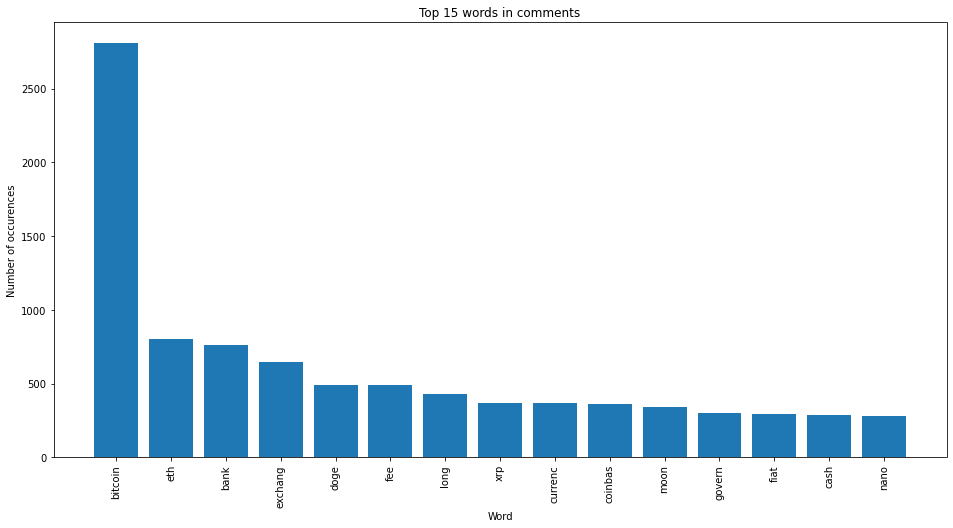

In [20]:
words = []
word_values = []
for i,j in get_top_n_words(top_comments['cleaned_comments'], stop, 15):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in comments');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

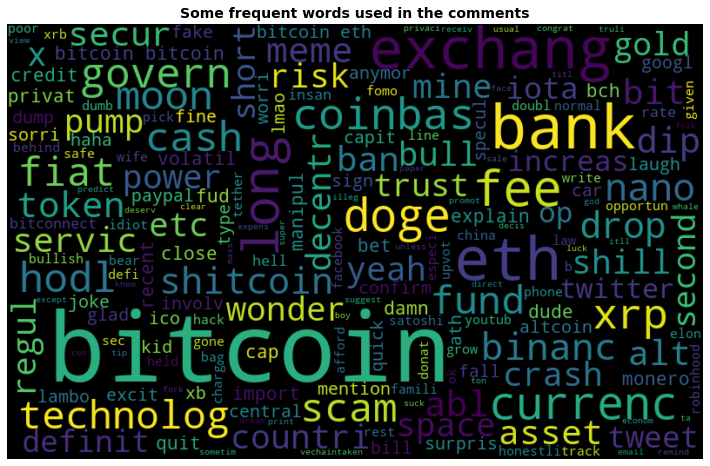

In [21]:
all_words = ' '.join([word for word in top_comments['cleaned_comments']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

Explore most frequent nouns, verbs, and adjectives

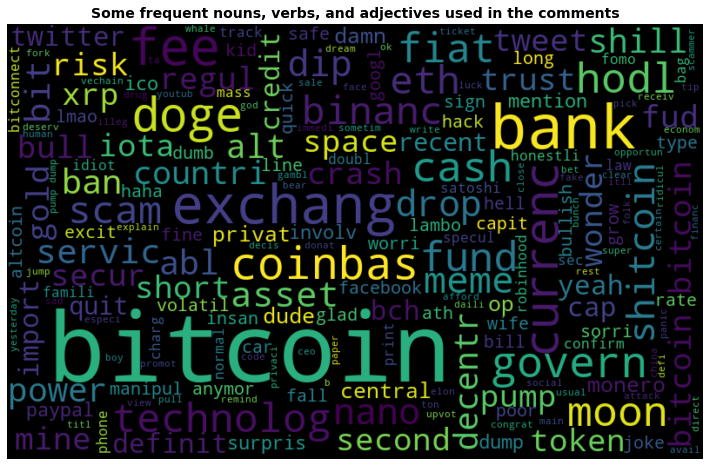

In [22]:
all_nouns = ' '.join([word for word in top_comments['nouns_verbs_adj']])
all_nouns
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns, verbs, and adjectives used in the comments", weight='bold', fontsize=14)
plt.show()

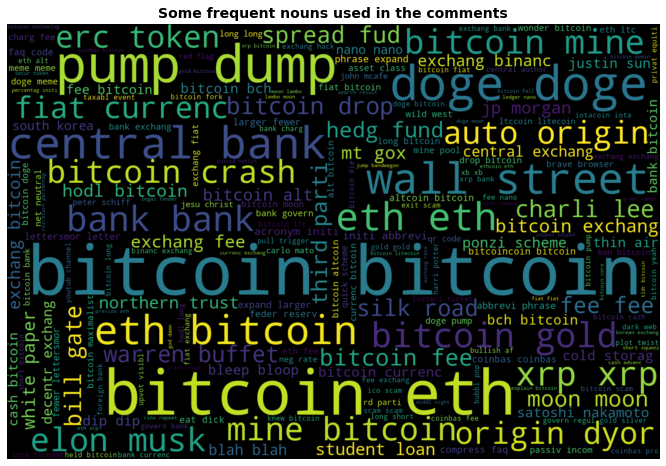

In [29]:
#get dictionary of top bigrams and frequencies
bigrams_freq = find_top_bigrams( top_comments['cleaned_comments'])   

#Generating wordcloud
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(bigrams_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()

# Topic Modeling

In [30]:
comments = list(top_comments['cleaned_comments'])

topics = 9
topic_words = 10
topic_names = ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges', 'Privacy', 'Ripple', 'Doge', 'Nano' ]
mindf = 5

### Count Vectorization

In [31]:
cv = CountVectorizer(stop_words=stop) 
X_cv = cv.fit_transform(comments)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Latent Semantic Analysis (LSA) with Count Vectorization

In [32]:
lsa_cv = TruncatedSVD(topics)
X_lsa_cv = lsa_cv.fit_transform(X_cv)
lsa_cv.explained_variance_ratio_

array([0.04108778, 0.02133358, 0.01380263, 0.01146537, 0.00924206,
       0.00798189, 0.0075218 , 0.00746269, 0.00736203])

In [33]:
display_topics(lsa_cv, cv.get_feature_names(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, bank, eth, exchang, bch, fee, long, fund, mine, currenc

Topic: ' CBDC '
bank, exchang, central, servic, govern, fund, trust, rate, currenc, fee

Topic: ' Ethereum '
eth, trust, fund, token, northern, fee, servic, asset, privat, equiti

Topic: ' Trusts '
trust, northern, servic, fund, privat, equiti, cherecwich, asset, hedg, administr

Topic: ' Exchanges '
eth, bank, central, rate, trust, northern, govern, bitcoin, asset, equiti

Topic: ' Privacy '
iota, nano, doge, xrp, govern, fud, technolog, mail, shill, spread

Topic: ' Ripple '
nano, fee, iota, central, govern, neg, rate, mail, charg, cryptographi

Topic: ' Doge '
nano, doge, shill, fee, neg, bank, brigad, northern, trust, spread

Topic: ' Nano '
xrp, nano, fud, spread, shill, exchang, brigad, troll, fish, sec


#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [34]:
nmf_cv = NMF(topics)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
# nmf_cv.explained_variance_ratio_

In [35]:
display_topics(nmf_cv, cv.get_feature_names(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, bch, energi, mine, gold, fork, long, origin, alt, fiat

Topic: ' CBDC '
bank, central, rate, currenc, govern, neg, morgan, crisi, exchang, servic

Topic: ' Ethereum '
eth, decentr, token, long, ico, coinbas, short, central, space, wbitcoin

Topic: ' Trusts '
trust, servic, northern, fund, privat, asset, equiti, cherecwich, token, hedg

Topic: ' Exchanges '
exchang, fee, coinbas, binanc, fiat, fund, charg, lightn, paypal, shitcoin

Topic: ' Privacy '
iota, govern, technolog, mail, cryptographi, cypherpunk, privaci, secur, long, bosch

Topic: ' Ripple '
doge, meme, pump, moon, currenc, robinhood, dash, brah, joke, bit

Topic: ' Doge '
nano, shill, fud, spread, brigad, neg, troll, hord, currenc, fish

Topic: ' Nano '
xrp, secur, fud, pump, sec, coinbas, lawsuit, dump, sale, brah


#### LDA with Count Vectorization 

In [40]:
X_cv = X_cv.transpose()

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(X_cv)

# save a mapping (dict) of row id to word (token) for later use by gensim
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda_cv = models.LdaModel(corpus=corpus, num_topics=topics, id2word=id2word, passes=5)

lda_cv.print_topics()

[(0,
  '0.056*"eth" + 0.029*"moon" + 0.018*"binanc" + 0.018*"dip" + 0.012*"yeah" + 0.012*"paypal" + 0.011*"lambo" + 0.011*"haha" + 0.010*"damn" + 0.009*"shill"'),
 (1,
  '0.034*"nano" + 0.017*"dump" + 0.017*"pump" + 0.014*"bch" + 0.013*"youtub" + 0.010*"tether" + 0.010*"tron" + 0.009*"ta" + 0.009*"fork" + 0.009*"scammer"'),
 (2,
  '0.038*"doge" + 0.036*"xrp" + 0.029*"fee" + 0.029*"coinbas" + 0.008*"code" + 0.007*"ico" + 0.007*"sec" + 0.007*"car" + 0.007*"attack" + 0.007*"main"'),
 (3,
  '0.030*"meme" + 0.015*"brave" + 0.013*"kid" + 0.012*"laugh" + 0.011*"surpris" + 0.011*"dumb" + 0.010*"titl" + 0.009*"congrat" + 0.009*"remind" + 0.009*"ban"'),
 (4,
  '0.020*"long" + 0.015*"technolog" + 0.012*"token" + 0.012*"gold" + 0.011*"second" + 0.009*"decentr" + 0.009*"bet" + 0.009*"space" + 0.009*"monero" + 0.009*"cap"'),
 (5,
  '0.025*"shitcoin" + 0.018*"bull" + 0.012*"tweet" + 0.012*"alt" + 0.010*"econom" + 0.009*"twitter" + 0.008*"cash" + 0.008*"joke" + 0.008*"insan" + 0.008*"elon"'),
 (6,
  '

## TF-IDF Vectorizer

In [41]:
tfid = TfidfVectorizer(stop_words= stop, min_df=mindf)
X_tfid = tfid.fit_transform(comments)
# pd.DataFrame(X_tfid.toarray(), columns=tfid.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization 

In [42]:
nmf_tfid = NMF(topics)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)

In [43]:
display_topics(nmf_tfid, tfid.get_feature_names(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, alt, mine, gold, currenc, drop, bch, cash, crash, altcoin

Topic: ' CBDC '
doge, pump, elon, mine, joke, wonder, tweet, dump, currenc, cheap

Topic: ' Ethereum '
eth, alt, token, ltc, ath, long, short, fee, litecoin, wonder

Topic: ' Trusts '
moon, lambo, farm, upvot, alt, tip, congrat, count, boy, shitcoin

Topic: ' Exchanges '
bank, fee, exchang, coinbas, binanc, fiat, currenc, central, cash, servic

Topic: ' Privacy '
xrp, dump, pump, scam, coinbas, glad, sec, xlm, bullish, ltc

Topic: ' Ripple '
meme, joke, dream, bull, upvot, elon, twitter, op, yeah, laugh

Topic: ' Doge '
nano, drop, fee, ledger, iota, shill, feeless, binanc, bitgrail, second

Topic: ' Nano '
hodl, dip, long, shitcoin, drop, pump, crash, dump, till, bag


## Final topic model 

*NMF with Count Vectorization got the most clear topics with a topic number of 9*

#### Create document topic matrix

In [44]:
#get topic probablitity df
nmf_cv_probs = prob_df(X_nmf_cv, ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#add date and comments
nmf_cv_probs['date'] = top_comments['date']
nmf_cv_probs['comment'] = top_comments['comment']
nmf_cv_probs['comments_cleaned'] = top_comments['cleaned_comments']

nmf_cv_probs['topic_choice'].value_counts(normalize=True)

Bitcoin      0.221453
Privacy      0.193427
Exchanges    0.138275
Ripple       0.091339
Trusts       0.083347
Nano         0.082166
Ethereum     0.068659
Doge         0.067984
CBDC         0.053351
Name: topic_choice, dtype: float64

#### Create Word Topic Matrix

In [45]:
word_df = topic_matrix(nmf_cv, cv.get_feature_names(), ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#svae as csv in data folder
word_df.to_csv('../Data/word_topic_analysis.csv')

#### Get top words of each topic

In [48]:
replace_words = {'energi': 'energy', 
                 'servic': 'service',
                 'currenc': 'currency',
                 'decentr': 'decentralized',
                 'neg': 'negative',
                 'privat': 'private',
                 'coinbas': 'coinbase',
                 'binanc': 'binance',
                 'equiti': 'equity',
                 'charg': 'charge',
                 'secur': 'secure',
                 'technolog': 'technology',
                 'cryptographi': 'cryptography'}

top_topic_words_df = top_topics_df(nmf_cv, cv.get_feature_names(), 10, topic_names, replace_words)
print(top_topic_words_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 1 to 9
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Bitcoin_words     9 non-null      object 
 1   Bitcoin_values    9 non-null      float64
 2   CBDC_words        9 non-null      object 
 3   CBDC_values       9 non-null      float64
 4   Ethereum_words    9 non-null      object 
 5   Ethereum_values   9 non-null      float64
 6   Trusts_words      9 non-null      object 
 7   Trusts_values     9 non-null      float64
 8   Exchanges_words   9 non-null      object 
 9   Exchanges_values  9 non-null      float64
 10  Privacy_words     9 non-null      object 
 11  Privacy_values    9 non-null      float64
 12  Ripple_words      9 non-null      object 
 13  Ripple_values     9 non-null      float64
 14  Doge_words        9 non-null      object 
 15  Doge_values       9 non-null      float64
 16  Nano_words        9 non-null      object 
 17  N

In [49]:
#save as csv on data folder
top_topic_words_df.to_csv('../Data/top_topic_words.csv')

## Sentiment Analysis

In [50]:
comment_topic_sentiment_df = get_sentiments(nmf_cv_probs)

In [51]:
comment_topic_sentiment_price_df = comment_topic_sentiment_df.copy()


#add crypto prices to comment_topic_sentiment_df
cryptos = ['BTC', 'ETH', 'XRP','NANO', 'DOGE']
for c in cryptos:
    name = c+'_price'
    comment_topic_sentiment_price_df[name] = top_comments[c]

In [52]:
comment_topic_sentiment_price_df.head()

,Bitcoin,CBDC,Ethereum,Trusts,Exchanges,Privacy,Ripple,Doge,Nano,topic_choice,...,comments_cleaned,compound,positive,negative,sentiment,BTC_price,ETH_price,XRP_price,NANO_price,DOGE_price
0,0.00137,0.00000,0.00013,0.00000,0.00000,0.00236,0.00323,0.00015,0.00352,Nano,...,hing tweet billionair,-0.3400,0.000,0.118,negative,37677.34,1667.22,0.3977,3.62,0.03735
1,0.10910,0.00002,0.00927,0.00894,0.00026,0.00446,0.01214,0.00000,0.00736,Bitcoin,...,obsess elon musk space signific tweet rekt bor...,-0.7906,0.026,0.141,negative,37677.34,1667.22,0.3977,3.62,0.03735
2,0.00139,0.00000,0.00000,0.00000,0.00185,0.00000,0.19089,0.00195,0.00359,Ripple,...,tbh blame elon tho yolo doge dumb af yolo twee...,0.2883,0.122,0.088,posititve,37677.34,1667.22,0.3977,3.62,0.03735
3,0.00442,0.00000,0.00993,0.00000,0.00368,0.01192,0.00207,0.00000,0.00135,Privacy,...,relev cryptodltfintech obsess fascin idol norm...,0.1280,0.078,0.116,posititve,37677.34,1667.22,0.3977,3.62,0.03735
4,0.00002,0.00000,0.00034,0.00000,0.00000,0.00000,0.35001,0.00000,0.00000,Ripple,...,elon hundr doge dip tweet doge pull shock,0.7321,0.174,0.000,posititve,37677.34,1667.22,0.3977,3.62,0.03735


In [53]:
#save as csv on data folder
comment_topic_sentiment_price_df.to_csv('../Data/topic_sentiment_analysis_comments.csv')